In [1]:
#Connection Oracle

import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import urllib

# Load .env variables
load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_SERVICE = os.getenv("DB_SERVICE")

# Quote password for URL safety
password_quoted = urllib.parse.quote_plus(DB_PASSWORD)

#SQLAlchemy Oracle connection string
connection_string = (
    f"oracle+cx_oracle://{DB_USER}:{password_quoted}@{DB_HOST}:{DB_PORT}/?service_name={DB_SERVICE}"
)

# Create SQLAlchemy engine
engine = create_engine(connection_string)

print("Connected to Oracle")

print("DB_USER:", DB_USER)
print("DB_PASSWORD:", DB_PASSWORD)
print("DB_HOST:", DB_HOST)
print("DB_PORT:", DB_PORT)
print("DB_SERVICE:", DB_SERVICE)


Connected to Oracle
DB_USER: SAMAC_V2
DB_PASSWORD: password2015
DB_HOST: 192.168.100.80
DB_PORT: 1521
DB_SERVICE: mpmsi


In [2]:
start_date = '2024-06-01'
end_date = '2025-07-31'
selected_entity = '12'
selected_port = ''
selected_pda_code = ''

if selected_port and not selected_port.startswith(selected_entity):
    print(f"Le port '{selected_port}' ne correspond pas à l'entité '{selected_entity}'. Filtre port ignoré.")
    selected_port = None
else:
    print(f"Filtre port activé : {selected_port if selected_port else 'Aucun'}")

print("Filtres utilisés :")
print(f"- Entité : {selected_entity}")
print(f"- Port : {selected_port if selected_port else 'Aucun (ignoré)'}")
print(f"- Code PDA : {selected_pda_code if selected_pda_code else 'Aucun (tous)'}")
print(f"- Période : du {start_date} au {end_date}")


Filtre port activé : Aucun
Filtres utilisés :
- Entité : 12
- Port : Aucun (ignoré)
- Code PDA : Aucun (tous)
- Période : du 2024-06-01 au 2025-07-31


In [3]:
def use_case_1_pda_precis(start_date, end_date, selected_pda_code):
    if not selected_pda_code:
        print("Aucun PDA sélectionné.")
        return
    
    print("Cas d'usage #1 : Nombre déclarations pour un PDA précis avec filtre période")
    
    query = """
    SELECT 
        COUNT(DISTINCT a.NUMEROVISA) AS total_declarations_distinct
    FROM 
        pe_prd_declarationpeche a 
    INNER JOIN 
        pe_prd_sourceespdc b ON a.id = b.id_refdeclaration
    INNER JOIN 
        pm_ref_espece c ON c.id = b.id_refespece
    WHERE 
        a.NUMEROVISA LIKE :pda_code
        AND a.DATEDECLARATION BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
    """
    
    params = {
        "pda_code": f"%{selected_pda_code}%",
        "start_date": start_date,
        "end_date": end_date
    }
    
    df = pd.read_sql_query(query, engine, params=params)
    print(df)

In [4]:
#test use case 1
#use_case_1_pda_precis('2025-02-01', '2025-02-17', 'PDA354-2025')

In [5]:
def use_case_2_ports_periode(start_date, end_date):
    print("Cas d'usage #2 : Nombre déclarations dans différents ports avec filtre période")
    
    query = """
    SELECT 
      e.CODE AS ENTITE_CODE,
      e.NOM AS ENTITE_NOM,
      COUNT(DISTINCT CASE 
          WHEN REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
               AND TO_NUMBER(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3)) BETWEEN 286 AND 400
          THEN a.ID
      END) AS NOMBRE_DECLARATIONS_NEW_PDA
    FROM 
      pe_prd_declarationpeche a
    INNER JOIN 
      adm_ref_entite e ON e.id = a.id_refentitedeclar
    WHERE 
      a.NUMEROVISA LIKE '%PDA%'
      AND INSTR(a.NUMEROVISA, 'PDA') > 0
      AND a.DATEDECLARATION BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
      AND REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
    GROUP BY 
      e.CODE,
      e.NOM
    ORDER BY 
      e.CODE
    """
    
    params = {
        "start_date": start_date,
        "end_date": end_date
    }
    
    df = pd.read_sql_query(query, engine, params=params)
    print(df)
    df.plot(
        kind='bar',
        x='entite_nom',
        y='nombre_declarations_new_pda',
        legend=False,
        title='Nombre déclarations par port'
    )
    plt.show()

In [6]:
#test use case 2
#use_case_2_ports_periode('2025-03-01', '2025-07-31')

In [7]:
def use_case_3_ports_per_month_dynamic(year, months):
    print(f"Cas d'usage #3 : Nombre déclarations dans différents ports par mois (mois {months})")
    
    # Convert months list to comma-separated string for SQL IN clause
    months_str = ", ".join(str(m) for m in months)
    
    query = f"""
    SELECT 
      e.CODE AS ENTITE_CODE,
      e.NOM AS ENTITE_NOM,
      EXTRACT(MONTH FROM a.DATEDECLARATION) AS MOIS,
      COUNT(DISTINCT CASE 
          WHEN REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
               AND TO_NUMBER(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3)) BETWEEN 286 AND 400
          THEN a.ID
      END) AS NOMBRE_DECLARATIONS_NEW_PDA
    FROM 
      pe_prd_declarationpeche a
    INNER JOIN 
      adm_ref_entite e ON e.id = a.id_refentitedeclar
    WHERE 
      a.NUMEROVISA LIKE '%PDA%'
      AND INSTR(a.NUMEROVISA, 'PDA') > 0
      AND EXTRACT(YEAR FROM a.DATEDECLARATION) = :year
      AND EXTRACT(MONTH FROM a.DATEDECLARATION) IN ({months_str})
      AND REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
    GROUP BY 
      e.CODE,
      e.NOM,
      EXTRACT(MONTH FROM a.DATEDECLARATION)
    ORDER BY 
      e.CODE,
      MOIS
    """
    
    df = pd.read_sql_query(query, engine, params={"year": year})
    print(df)
    
    import seaborn as sns
    plt.figure(figsize=(14,7))
    sns.barplot(data=df, x='entite_nom', y='nombre_declarations_new_pda', hue='mois')
    plt.xticks(rotation=90)
    plt.title(f'Nombre déclarations par port et mois {months} {year}')
    plt.xlabel('Port')
    plt.ylabel('Nombre déclarations')
    plt.legend(title='Mois')
    plt.tight_layout()
    plt.show()



In [8]:
# Test mois mars avril mai
#use_case_3_ports_per_month_dynamic(2025, [3,4,5])

In [9]:
def use_case_3_declarations_par_port_et_mois(start_date, end_date):
    print("Cas d'usage #3 : Nombre déclarations par port et par mois pour une période donnée")
    
    query = """
        SELECT
            TO_CHAR(d.datedeclaration, 'YYYY-MM') AS mois,
            e.CODE AS entite_code,
            e.NOM AS entite_nom,
            COUNT(*) AS nb_decl_par_mois_port
        FROM PE_PRD_DECLARATIONPECHE d
        JOIN ADM_REF_ENTITE e ON d.id_refentitedeclar = e.ID
        WHERE d.datedeclaration BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
        GROUP BY TO_CHAR(d.datedeclaration, 'YYYY-MM'), e.CODE, e.NOM
        ORDER BY mois, e.CODE
    """
    
    df = pd.read_sql_query(query, engine, params={"start_date": start_date, "end_date": end_date})
    print(df.head())
    
   
    import seaborn as sns
    plt.figure(figsize=(14,7))
    sns.barplot(data=df, x='entite_nom', y='nb_decl_par_mois_port', hue='mois')
    plt.xticks(rotation=90)
    plt.title(f'Nombre déclarations par port et par mois du {start_date} au {end_date}')
    plt.xlabel('Port')
    plt.ylabel('Nombre déclarations')
    plt.legend(title='Mois')
    plt.tight_layout()
    plt.show()

In [10]:
# Test
#use_case_3_declarations_par_port_et_mois("2025-03-01", "2025-03-31")

In [11]:
def use_case_4_ports_par_mois_periode(start_date, end_date):
    print("Cas d'usage #4 : Nombre déclarations dans différents ports par mois (avec période personnalisée)")

    query = """
    SELECT 
      e.CODE AS entite_code,
      e.NOM AS entite_nom,
      EXTRACT(MONTH FROM a.DATEDECLARATION) AS mois,
      COUNT(DISTINCT CASE 
          WHEN REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
               AND TO_NUMBER(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3)) BETWEEN 286 AND 400
          THEN a.ID
      END) AS nombre_declarations_new_pda
    FROM 
      pe_prd_declarationpeche a
    INNER JOIN 
      adm_ref_entite e ON e.id = a.id_refentitedeclar
    WHERE 
      a.NUMEROVISA LIKE '%PDA%'
      AND INSTR(a.NUMEROVISA, 'PDA') > 0
      AND a.DATEDECLARATION BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
      AND REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
    GROUP BY 
      e.CODE,
      e.NOM,
      EXTRACT(MONTH FROM a.DATEDECLARATION)
    ORDER BY 
      e.CODE,
      mois
    """

    df = pd.read_sql_query(query, engine, params={"start_date": start_date, "end_date": end_date})
    print(df.head())

    import seaborn as sns
    plt.figure(figsize=(14,7))
    sns.barplot(data=df, x='entite_nom', y='nombre_declarations_new_pda', hue='mois')
    plt.xticks(rotation=90)
    plt.title(f'Nombre déclarations par port et mois du {start_date} au {end_date}')
    plt.xlabel('Port')
    plt.ylabel('Nombre déclarations')
    plt.legend(title='Mois')
    plt.tight_layout()
    plt.show()


In [12]:
#use_case_4_ports_par_mois_periode("2025-03-01", "2025-07-31")

In [13]:
def use_case_5_un_port_periode(port_code, start_date, end_date):
    print(f"Cas d'usage #5 : Nombre de déclarations dans le port {port_code} entre {start_date} et {end_date}")

    query = """
    SELECT 
      e.CODE AS entite_code,
      e.NOM AS entite_nom,
      COUNT(DISTINCT CASE 
          WHEN REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
               AND TO_NUMBER(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3)) BETWEEN 286 AND 400
          THEN a.ID
      END) AS nombre_declarations_new_pda
    FROM 
      pe_prd_declarationpeche a
    INNER JOIN 
      adm_ref_entite e ON e.id = a.id_refentitedeclar
    WHERE 
      a.NUMEROVISA LIKE '%PDA%'
      AND INSTR(a.NUMEROVISA, 'PDA') > 0
      AND e.CODE = :port_code
      AND a.DATEDECLARATION BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
      AND REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
    GROUP BY 
      e.CODE,
      e.NOM
    """

    df = pd.read_sql_query(query, engine, params={"port_code": port_code, "start_date": start_date, "end_date": end_date})
    print(df)

    if df.empty:
        print("Aucun résultat trouvé pour ce port dans la période sélectionnée.")
        return

    plt.figure(figsize=(8,5))
    plt.bar(df["entite_nom"], df["nombre_declarations_new_pda"], color='teal')
    plt.title(f"Déclarations PDA dans le port {df['entite_nom'][0]} entre {start_date} et {end_date}")
    plt.xlabel("Port")
    plt.ylabel("Nombre déclarations")
    plt.tight_layout()
    plt.show()


In [14]:
#use_case_5_un_port_periode("10/1", "2025-03-01", "2025-07-31")

In [15]:
def use_case_6_entite_mere_periode(entite_mere_code, start_date, end_date):
    print(f"Cas d'usage #6 : Déclarations pour entité mère {entite_mere_code} et ses ports entre {start_date} et {end_date}")

    query = """
    SELECT 
      e.CODE AS entite_code,
      e.NOM AS entite_nom,
      COUNT(DISTINCT CASE 
          WHEN REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
               AND TO_NUMBER(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3)) BETWEEN 286 AND 400
          THEN a.ID
      END) AS nombre_declarations_new_pda
    FROM 
      pe_prd_declarationpeche a
    INNER JOIN 
      adm_ref_entite e ON e.id = a.id_refentitedeclar
    WHERE 
      a.NUMEROVISA LIKE '%PDA%'
      AND INSTR(a.NUMEROVISA, 'PDA') > 0
      AND e.CODE LIKE :entite_mere_pattern
      AND a.DATEDECLARATION BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
      AND REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
    GROUP BY 
      e.CODE,
      e.NOM
    """

    entite_mere_pattern = f"{entite_mere_code}%"

    df = pd.read_sql_query(query, engine, params={
        "entite_mere_pattern": entite_mere_pattern,
        "start_date": start_date,
        "end_date": end_date
    })

    print(df)

    if df.empty:
        print("Aucun résultat trouvé pour cette entité mère dans la période sélectionnée.")
        return

    plt.figure(figsize=(10,5))
    plt.bar(df["entite_nom"], df["nombre_declarations_new_pda"], color='indigo')
    plt.title(f"Déclarations PDA pour entité mère {entite_mere_code} entre {start_date} et {end_date}")
    plt.xlabel("Port")
    plt.ylabel("Nombre déclarations")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [16]:
#use_case_6_entite_mere_periode("10", "2025-03-01", "2025-07-31")

In [17]:
def use_case_7_vue_complete_entite_mere(entite_mere_code, start_date, end_date):
    print(f"Cas d'usage #7 : Vue complète de l'entité mère {entite_mere_code} (mois x port) entre {start_date} et {end_date}")

    query = """
    SELECT 
      e.CODE AS entite_code,
      e.NOM AS entite_nom,
      TO_CHAR(a.DATEDECLARATION, 'YYYY-MM') AS mois,
      COUNT(DISTINCT CASE 
          WHEN REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
               AND TO_NUMBER(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3)) BETWEEN 286 AND 400
          THEN a.ID
      END) AS nombre_declarations_new_pda
    FROM 
      pe_prd_declarationpeche a
    INNER JOIN 
      adm_ref_entite e ON e.id = a.id_refentitedeclar
    WHERE 
      a.NUMEROVISA LIKE '%PDA%'
      AND INSTR(a.NUMEROVISA, 'PDA') > 0
      AND e.CODE LIKE :entite_mere_pattern
      AND a.DATEDECLARATION BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
      AND REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
    GROUP BY 
      e.CODE,
      e.NOM,
      TO_CHAR(a.DATEDECLARATION, 'YYYY-MM')
    ORDER BY 
      mois ASC, entite_code
    """

    entite_mere_pattern = f"{entite_mere_code}%"

    df = pd.read_sql_query(query, engine, params={
        "entite_mere_pattern": entite_mere_pattern,
        "start_date": start_date,
        "end_date": end_date
    })

    print(df)

    if df.empty:
        print("Aucun résultat trouvé pour cette entité mère et période.")
        return

    pivot = df.pivot(index="mois", columns="entite_nom", values="nombre_declarations_new_pda").fillna(0)

    pivot.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
    plt.title(f"Vue complète de l'entité mère {entite_mere_code} (Déclarations PDA par mois et port)")
    plt.xlabel("Mois")
    plt.ylabel("Nombre de déclarations")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
#use_case_7_vue_complete_entite_mere("10", "2025-03-01", "2025-07-31")

In [19]:
def use_case_8_declarations_par_espece(start_date, end_date):
    print(f"Cas d'usage #8 : Nombre déclarations par espèce entre {start_date} et {end_date} (PDA 286-400)")

    query = """
    SELECT 
      c.NOMCOMMUN AS espece,
      COUNT(DISTINCT CASE 
          WHEN REGEXP_LIKE(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3), '^[0-9]+$')
               AND TO_NUMBER(SUBSTR(a.NUMEROVISA, INSTR(a.NUMEROVISA, 'PDA') + 3, 3)) BETWEEN 286 AND 400
          THEN a.ID
      END) AS nombre_declarations_new_pda
    FROM 
      pe_prd_declarationpeche a
    INNER JOIN 
      pe_prd_sourceespdc b ON a.id = b.id_refdeclaration
    INNER JOIN 
      pm_ref_espece c ON c.id = b.id_refespece
    WHERE 
      a.NUMEROVISA LIKE '%PDA%'
      AND a.DATEDECLARATION BETWEEN TO_DATE(:start_date, 'YYYY-MM-DD') AND TO_DATE(:end_date, 'YYYY-MM-DD')
    GROUP BY 
      c.NOMCOMMUN
    ORDER BY 
      nombre_declarations_new_pda DESC
    """

    df = pd.read_sql_query(query, engine, params={"start_date": start_date, "end_date": end_date})

    print(df)

    plt.figure(figsize=(10, 6))
    plt.barh(df['espece'], df['nombre_declarations_new_pda'], color='skyblue')
    plt.xlabel('Nombre de déclarations')
    plt.ylabel('Espèce')
    plt.title(f'Nombre déclarations par espèce entre {start_date} et {end_date} ')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [20]:
def run_use_cases(start_date, end_date, selected_entity='', selected_port='', selected_pda_code=''):
    
    print(f"Filtres: start_date={start_date}, end_date={end_date}, entity={selected_entity}, port={selected_port}, pda_code={selected_pda_code}\n")
    
  
    
    if selected_pda_code:
        use_case_1_pda_precis(start_date, end_date, selected_pda_code)
    
    if selected_port:
        use_case_5_un_port_periode(selected_port, start_date, end_date)
    
    if selected_entity and not selected_port:
        # Use case 6 or 7 for entity + subports
        use_case_6_entite_mere_periode(selected_entity, start_date, end_date)
        use_case_7_vue_complete_entite_mere(selected_entity, start_date, end_date)
    
    # Always run generic port declarations over period (use case 2 or 4)
    use_case_2_ports_periode(start_date, end_date)
    use_case_4_ports_par_mois_periode(start_date, end_date)
    
  
    use_case_8_declarations_par_espece(start_date, end_date)


Filtres: start_date=2024-06-01, end_date=2025-07-31, entity=12, port=, pda_code=

Cas d'usage #6 : Déclarations pour entité mère 12 et ses ports entre 2024-06-01 et 2025-07-31
  entite_code entite_nom  nombre_declarations_new_pda
0        12/1    NTIREFT                         1555
1          12     DAKHLA                            8
2        12/2   LASSARGA                         6677
3        12/5  IMOUTLANE                            0
4        12/4   LAMHIRIZ                            0
5        12/3   LBOUIRDA                         3238


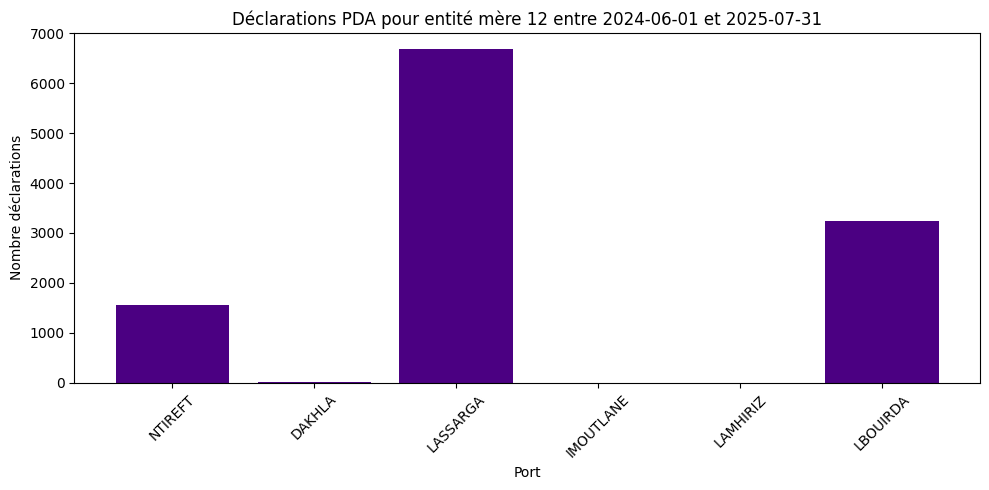

Cas d'usage #7 : Vue complète de l'entité mère 12 (mois x port) entre 2024-06-01 et 2025-07-31
   entite_code entite_nom     mois  nombre_declarations_new_pda
0           12     DAKHLA  2024-06                            0
1         12/1    NTIREFT  2024-06                            0
2         12/2   LASSARGA  2024-06                            0
3         12/3   LBOUIRDA  2024-06                            0
4         12/4   LAMHIRIZ  2024-06                            0
5         12/5  IMOUTLANE  2024-06                            0
6           12     DAKHLA  2024-07                            0
7         12/1    NTIREFT  2024-07                            0
8         12/2   LASSARGA  2024-07                            0
9         12/3   LBOUIRDA  2024-07                            0
10        12/4   LAMHIRIZ  2024-07                            0
11        12/5  IMOUTLANE  2024-07                            0
12          12     DAKHLA  2024-08                            0
13       

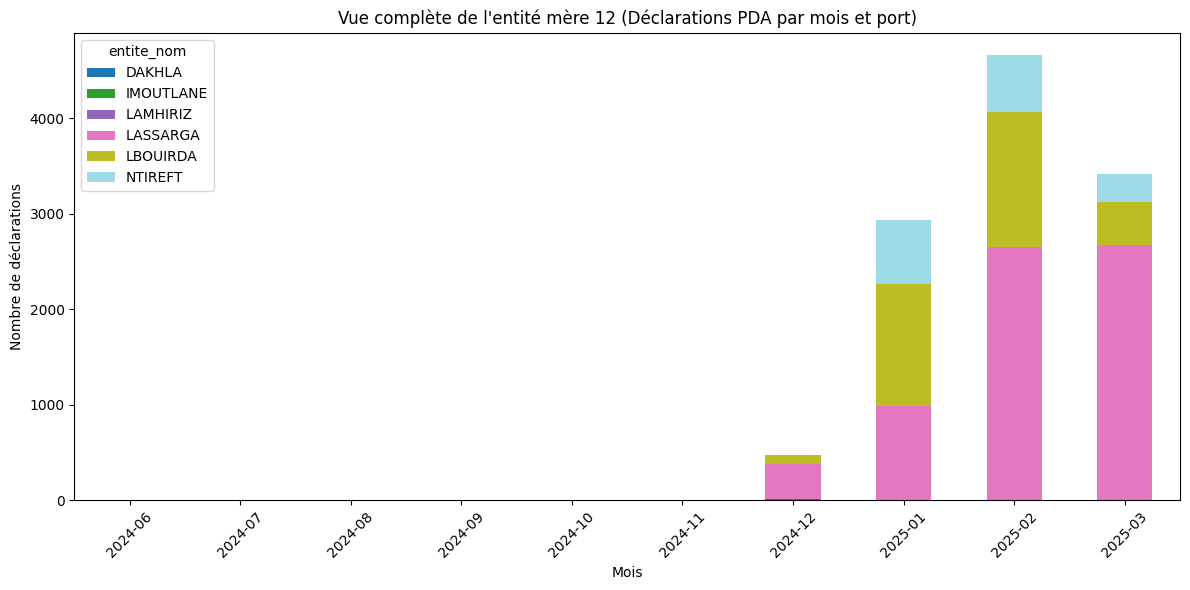

Cas d'usage #2 : Nombre déclarations dans différents ports avec filtre période
   entite_code         entite_nom  nombre_declarations_new_pda
0            1              NADOR                            0
1          1/2        RAS KEBDANA                            0
2          1/3         SIDI HSAIN                            0
3           10           LAAYOUNE                           65
4         10/1           BOUJDOUR                         5788
5         10/2       SIDI ELGHAZI                            0
6         10/3           AFTISSAT                            0
7         10/4             LAKRAA                            5
8           11            TAN-TAN                           24
9           12             DAKHLA                            8
10        12/1            NTIREFT                         1555
11        12/2           LASSARGA                         6677
12        12/3           LBOUIRDA                         3238
13        12/4           LAMHIRIZ      

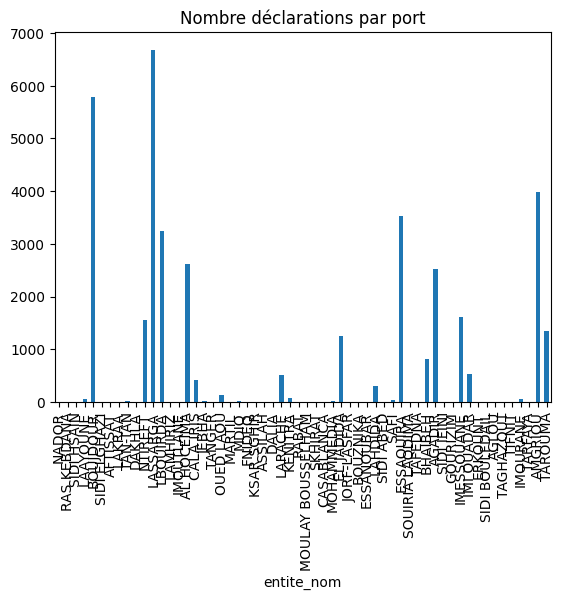

Cas d'usage #4 : Nombre déclarations dans différents ports par mois (avec période personnalisée)
  entite_code entite_nom  mois  nombre_declarations_new_pda
0           1      NADOR     1                            0
1           1      NADOR     2                            0
2           1      NADOR     3                            0
3           1      NADOR     6                            0
4           1      NADOR     7                            0


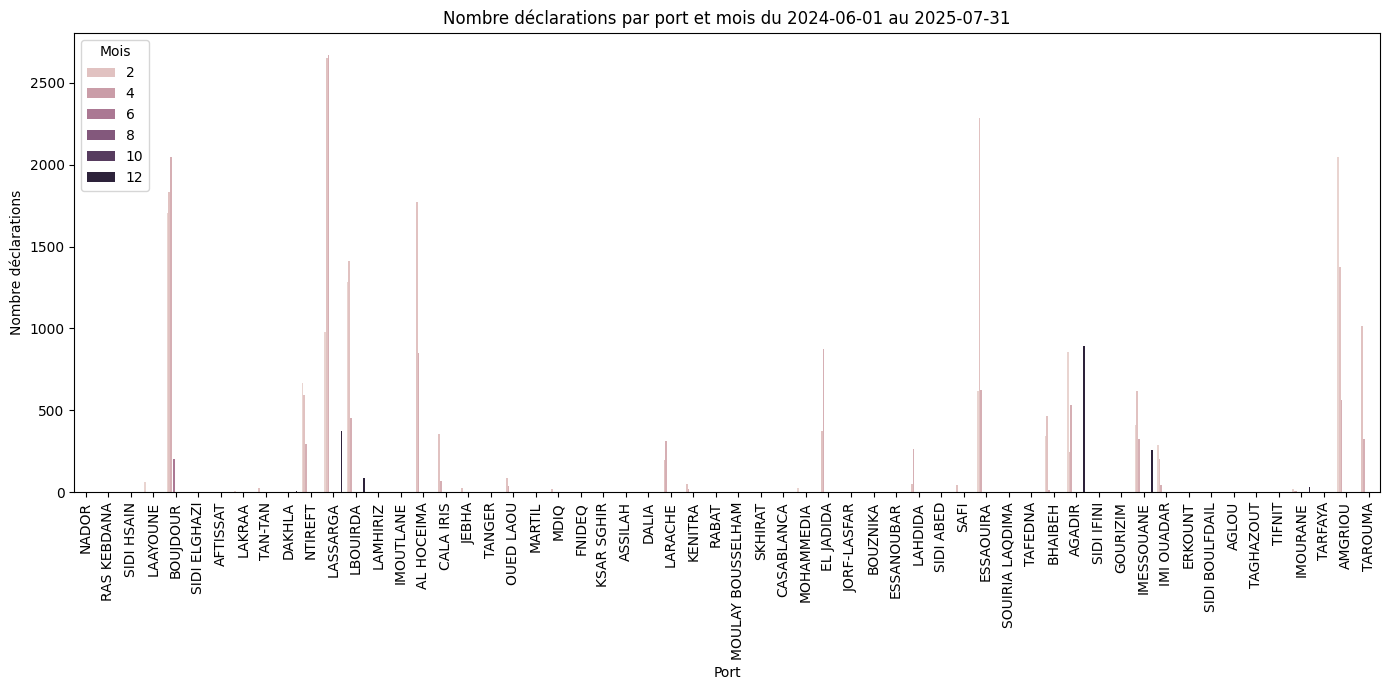

Cas d'usage #8 : Nombre déclarations par espèce entre 2024-06-01 et 2025-07-31 (PDA 286-400)
                espece  nombre_declarations_new_pda
0     POULPE (PIEUVRE)                        30190
1               SEICHE                         2546
2         CALAMAR VRAI                         1704
3                 RAIE                         1452
4             ABADECHE                         1451
..                 ...                          ...
145            BECASSE                            0
146               MORO                            0
147       SQUALE LICHE                            0
148           SANGLIER                            0
149  ALGUE GRACILLAIRE                            0

[150 rows x 2 columns]


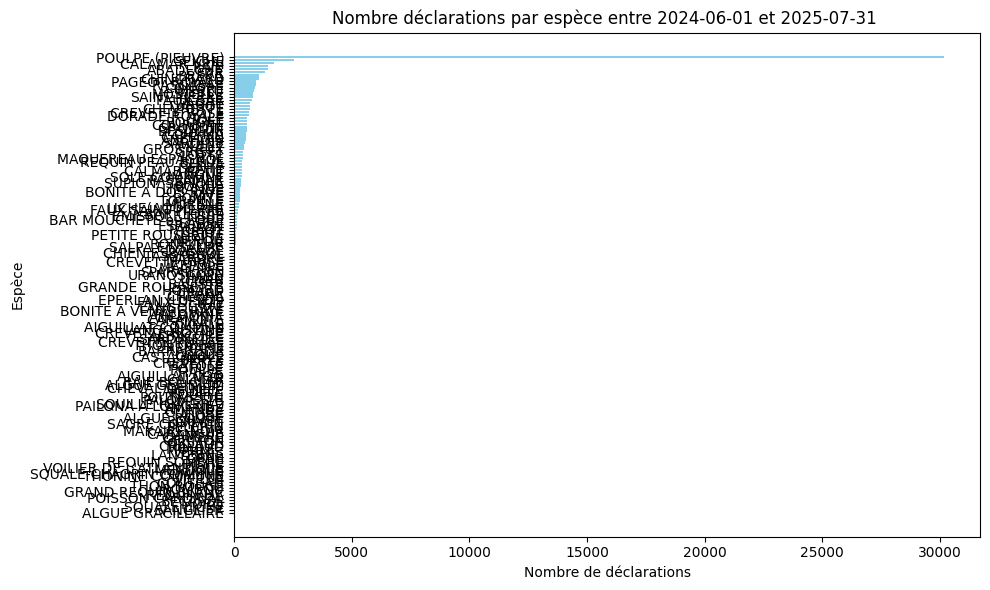

In [21]:
run_use_cases(start_date, end_date, selected_entity, selected_port, selected_pda_code)